# TCLAB CLP PID FF

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import matplotlib.gridspec as gridspec

from IPython.display import display, clear_output

from datetime import datetime
import tclab
import time

import os


import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_LAB import LL_RT, PID_RT, IMCTuning, Controller, Margins
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

# Parameters

In [20]:
# TSim = 10
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 58

Kp= 0.3578141359884931
T1p= 182.46415297298876
T2p= 12.839231012953283
thetap= 8.32912593907378


Kd=  0.25983971364459724
T1d = 255.2308010928982
T2d = 19.07109604060042
thetad = 30.999999996157488

#Process
P = Process({})
P.parameters['Kp'] = Kp
P.parameters['Tlead1'] = 0
P.parameters['Tlag1'] = T1p
P.parameters['Tlag2'] = T2p
P.parameters['theta'] = thetap
P.parameters['nInt'] = 0



gamma = 0.7
Kc, Ti, Td = IMCTuning(Kp, T1p, T2p, thetap, gamma, 'SOPDT')

alpha = 0.8
MVMin = 0
MVMax = 100

# Scenario

In [21]:
# # Scenario 1
# name = "CLP_DV_MAN_NOFF"
# ManPath = {0: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, TSim: PV0}
# DVPath = {0: 50, 1000: 60, TSim : 60}
# ActivateFF = False
# ManFF = True

# # # Scenario 2
# name = "CLP_DV_Man_FF"
# ManPath = {0: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, TSim: PV0}
# DVPath = {0: 50, 1000: 60, TSim : 60}
# ActivateFF = True
# ManFF = True

# # Scenario 3
# name = "CLP_DV_PID_NOFF"
# ManPath = {0: True, 400: False ,TSim: False}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, 1000: PV0-10, TSim: PV0-10}
# DVPath = {0: DV0, 1700: DV0+10, TSim : DV0+10}
# ActivateFF = False
# ManFF = False

# Scenario 4
name = "CLP_DV_PID_FF"
ManPath = {0: True, 400: False, TSim: False}
MVManPath = {0: MV0, TSim: MV0}
SPPath = {0: PV0, 1000: PV0-10, TSim: PV0-10}
DVPath = {0: DV0, 1500: DV0+10, TSim : DV0+10}
ActivateFF = True
ManFF = False


# TCLAB

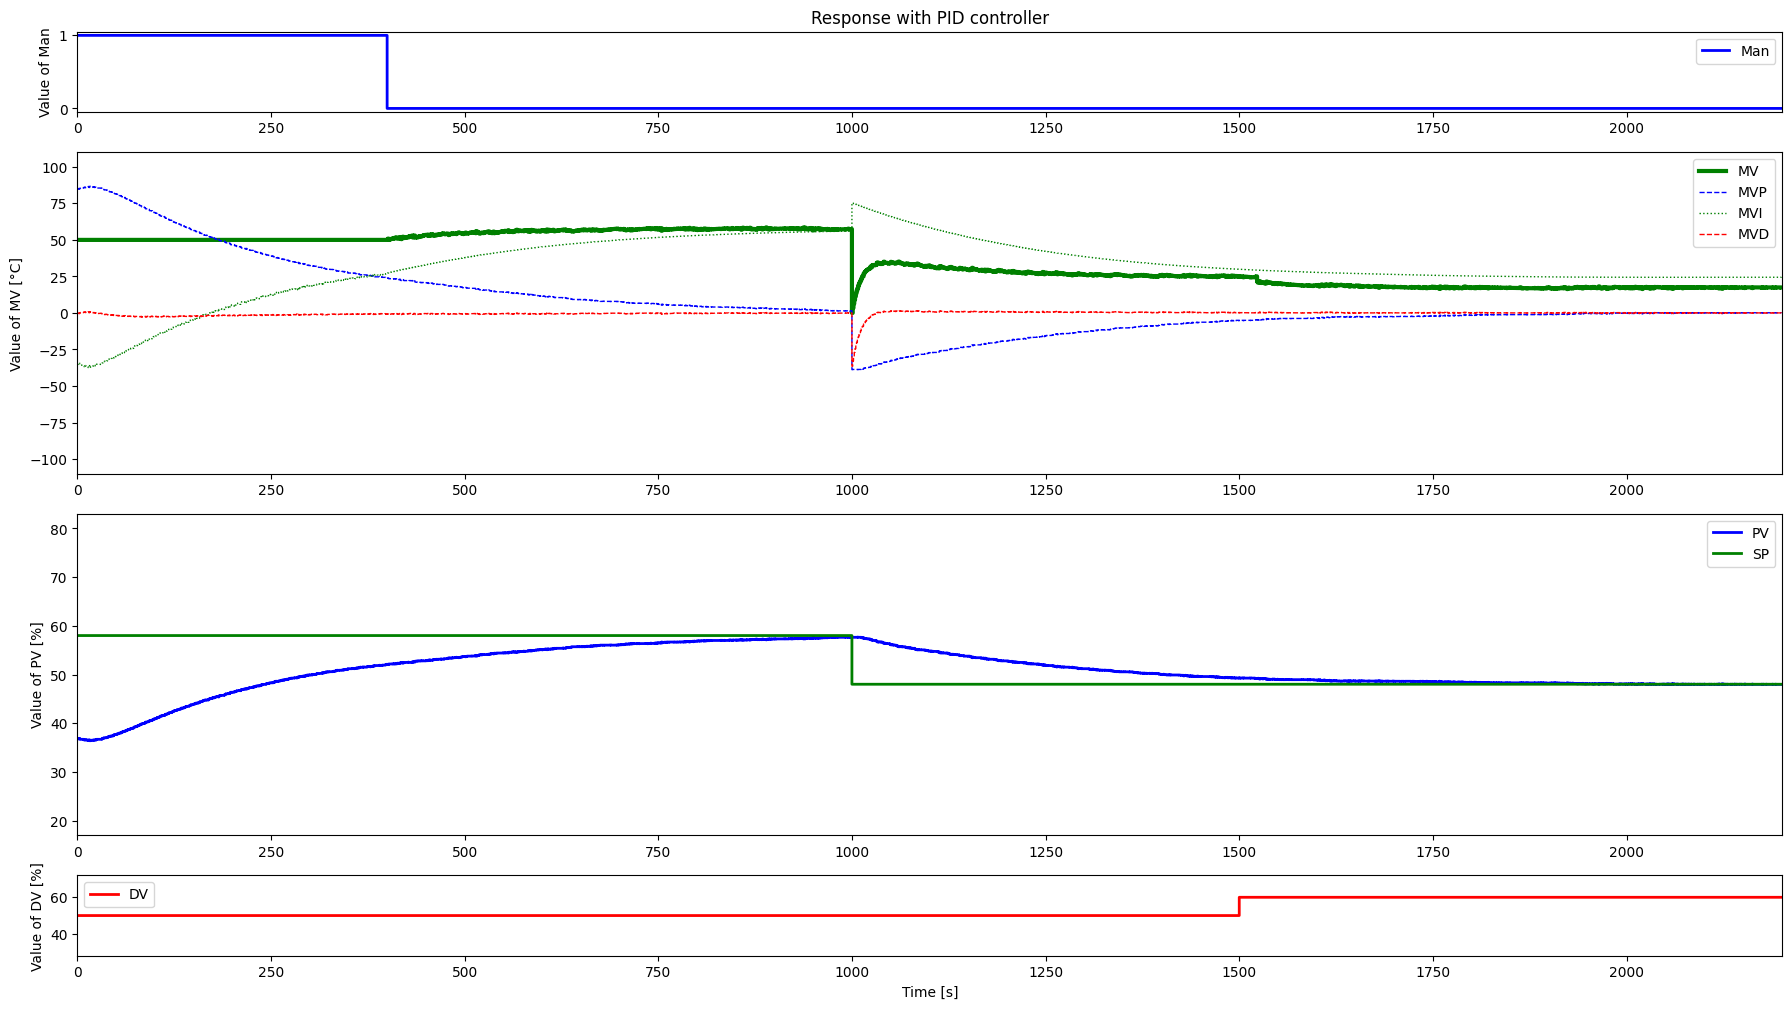

TCLab disconnected successfully.


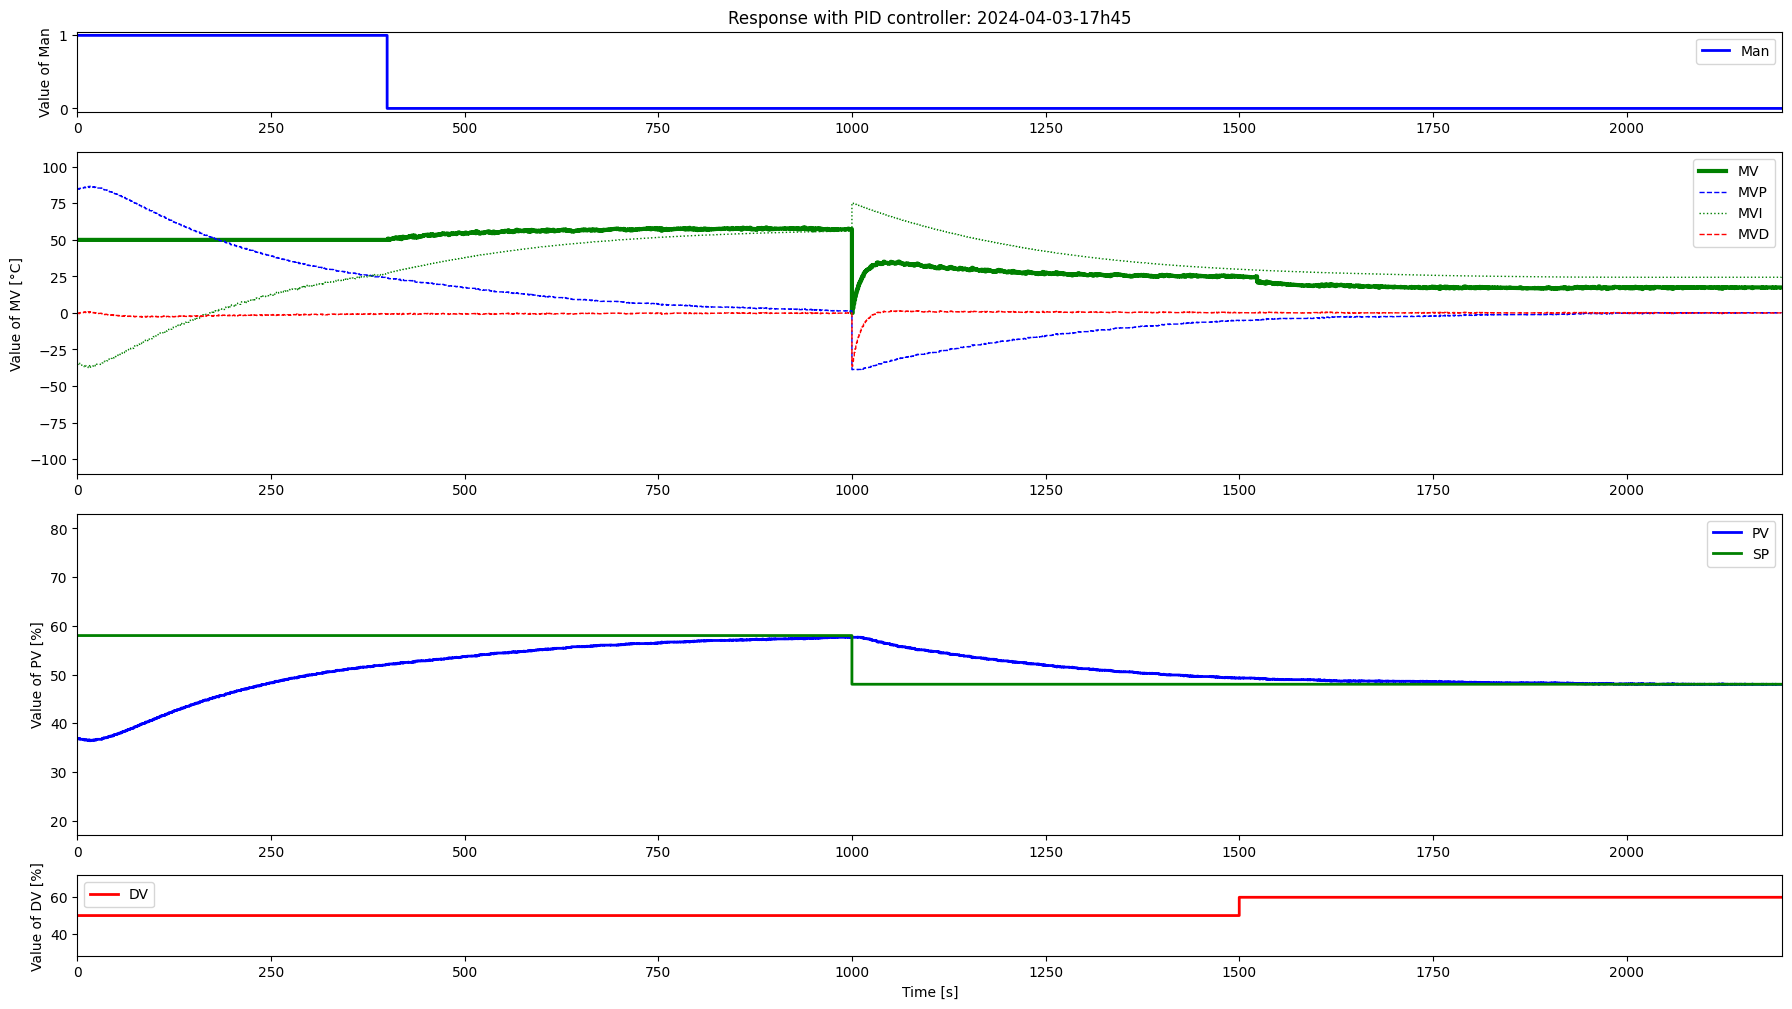

In [22]:
t = []
E = []
SP = []
DV = []
PV = []

MV = []
MVP = []
MVI = []
MVD = []

Man = []
MVMan = []
MVFF = []
MVFFDelay = []
MVFFLL1 = []

now = datetime.now()
datetime = now.strftime("%Y-%m-%d-%Hh%M")

lab = tclab.TCLab()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(22, 12), gridspec_kw={'height_ratios': [0.25, 1, 1, 0.25]})

l1, = ax1.step([0,TSim],[0,1],'b-',linewidth=2,label='Man',where='post')
ax1.set_ylabel('Value of Man')
ax1.set_title('Response with PID controller')
ax1.legend(loc='best')

l2, = ax2.step([0,TSim],[-100,100],'g-',linewidth=3,label='MV',where='post')
l3, = ax2.step([0,TSim],[-100,100],'b--',linewidth=1,label='MVP',where='post')
l4, = ax2.step([0,TSim],[-100,100],'g:',linewidth=1,label='MVI',where='post')
l5, = ax2.step([0,TSim],[-100,100],'r--',linewidth=1,label='MVD',where='post')
ax2.set_ylabel('Value of MV [°C]')
ax2.legend(loc='best')

l6, = ax3.step([0,TSim],[20,80],'b-',linewidth=2,label='PV',where='post')
l7, = ax3.step([0,TSim],[20,80],'g-',linewidth=2,label='SP',where='post')
ax3.set_ylabel('Value of PV [%]')
ax3.legend(loc='best') 

l8, = ax4.step([0,TSim],[30,70],'r-',linewidth=2,label='DV',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Value of DV [%]')
ax4.legend(loc='best') 

for i in range(0,N):
    t.append(i*Ts)

    if t[-1] == 0:
        last_time = time.time()
    
    PV.append(lab.T1)
    
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    lab.Q2(DV[-1])
    
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LL_RT(MVFFDelay,-(Kd/Kp),T1p,T1d,Ts,MVFFLL1)
    if ActivateFF:
        LL_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)
    else:
        LL_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)
    
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    lab.Q1(MV[-1])
    
    # Wait for sampling period Ts
    now = time.time()
    delta = now - last_time
    
    time.sleep(np.max([0, Ts - delta]))
    last_time = time.time()    
    
    l1.set_data(t,Man)
    l2.set_data(t,MV)
    l3.set_data(t,MVP)
    l4.set_data(t,MVI)
    l5.set_data(t,MVD)
    l6.set_data(t,PV)
    l7.set_data(t,SP)
    l8.set_data(t,DV)
    
    clear_output(wait=True)
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)
    
    display(fig)
   
lab.close()

# Conversion to array
t = np.array(t) 
MV = np.array(MV)
MVP = np.array(MVP)
MVI = np.array(MVI)
MVD = np.array(MVD)
PV = np.array(PV)
SP = np.array(SP)
DV = np.array(DV)
Man = np.array(Man)
my_data = np.vstack((t.T,MV.T,MVP.T,MVI.T,MVD.T,PV.T,SP.T,DV.T,Man.T))
my_data = my_data.T
nameFile = 'Data/TCLAB_PID_rt_'+ name + datetime + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,PV,SP,DV,Man',comments='') 

ax1.set_title('Response with PID controller: ' + datetime)
nameFile = 'Plots/Response_with_PID_controller_' + datetime

if not os.path.exists('Plots'):
    os.makedirs('Plots')
    
plt.savefig(nameFile + '.png',transparent=True)
plt.savefig(nameFile + '.pdf',transparent=True)